In [1]:
# 四半期の騰落率が大きく動いた銘柄の過去分析行う

In [2]:
# 読み込みファイルパスの設定とimportしたいmoduleパス(pythonパス)の設定
from pathlib import Path
import os, sys

CURRENT_DIR = Path(os.getcwd())
PJ_DIR = CURRENT_DIR.parent.parent
LIB_DIR = PJ_DIR / "lib"
DATA_DIR = PJ_DIR / "data" 

sys.path.append(str(LIB_DIR))

# notebook内で利用するmoduleのimport
from lib_dataprocess import KessanPl, PricelistFig, PricelistPl, MeigaralistPl, read_data
from lib_dataprocess import ShikihoPl, FinancequotePl, print_finance_quote, PricelistFig, KessanFig
import polars as pl
from datetime import date
from dateutil.relativedelta import relativedelta

fp = DATA_DIR/"reviced_pricelist.parquet"
df = read_data(fp)
RevPl = PricelistPl(df)

# dataの読み込み
fp = DATA_DIR/"raw_pricelist.parquet"
df = read_data(fp)
PPL = PricelistPl(df)

fp = DATA_DIR/"finance_quote.parquet"
df = read_data(fp)
FPL = FinancequotePl(df)
FPL.with_columns_market_cap()

fp = DATA_DIR/"meigaralist.parquet"
df = read_data(fp)
MPL = MeigaralistPl(df)

fp = DATA_DIR/"shikiho.parquet"
df = read_data(fp)
SPL = ShikihoPl(df)

In [3]:
#####
##### 評価日における四半期騰落率一覧
#####

In [4]:
valuation_date = date(2024, 9, 26)
KPl = KessanPl()
updown_rate_df = KPl.get_quater_settlement_price_updown_rate(valuation_date)
updown_rate_df

code,start_date,end_date,updown_rate
i64,date,date,f64
1301,2024-08-06,2024-11-06,4.67
1332,2024-08-07,2024-11-06,13.33
1333,2024-08-06,2024-11-11,-3.49
1375,2024-08-09,2024-11-07,6.73
1376,2024-07-11,2024-10-04,-3.01
…,…,…,…
9991,2024-07-26,2024-10-29,-9.93
9993,2024-07-12,2024-10-10,-5.32
9994,2024-08-10,2024-11-14,-5.28


In [5]:
#####
##### valuation_date時点で発表済四半期決算の業績成長率一覧(growth_rate_df)の作成
#####

In [6]:
KPL1 = KessanPl()
KPL2 = KessanPl()
KPL1.with_columns_growthrate_lastyear()
KPL2.with_columns_diff_growthrate()
KPL1.df = KPL1.df.filter(pl.col("settlement_type")=="四")
KPL2.df = KPL2.df.filter(pl.col("settlement_type")=="四")
df = KPL1.df.join(KPL2.df, on=["code", "settlement_date"], how="left")
KPL3 = KessanPl(df)
df =KPL3.get_latest_quater_settlements(valuation_date)
df = df.select([
    "code", "settlement_date", "announcement_date", "sales", "operating_income", "sales_growthrate", "diff_operating_income_growthrate"
])
growth_rate_df = df
growth_rate_df

code,settlement_date,announcement_date,sales,operating_income,sales_growthrate,diff_operating_income_growthrate
i64,date,date,i64,i64,f64,f64
1301,2024-06-30,2024-08-05,68204,3102,9.4,11.7
1332,2024-06-30,2024-08-06,220644,9724,10.4,0.0
1333,2024-06-30,2024-08-05,256928,7657,2.4,-0.5
1375,2024-06-30,2024-08-08,10172,-77,22.9,12.5
1376,2024-05-31,2024-07-10,23224,1150,1.9,-16.0
…,…,…,…,…,…,…
9991,2024-06-30,2024-07-25,26954,1366,-14.5,-2.5
9993,2024-05-31,2024-07-11,24969,-408,1.8,-108.5
9994,2024-06-30,2024-08-09,39151,1286,0.6,-14.9


In [20]:
#####
##### 評価dfの作成：　updown_rate_dfとgrowth_rate_dfをjoinして必要な列を残す
#####

In [96]:
df = growth_rate_df.join(updown_rate_df, on=["code"], how="left")
df = df.with_columns([pl.lit(valuation_date).alias("評価日")])
# 営業利益率列を追加
df = df.with_columns([
    (pl.lit(100) * pl.col("operating_income")/pl.col("sales")).round(2).alias("営業利益率")
])
df = df.select([
    "code",
    "評価日",
    "settlement_date",
    "sales",	
    "operating_income",	
    "営業利益率",
    "sales_growthrate",	
    "diff_operating_income_growthrate",
    "updown_rate"
])

target_df = df

# 統計データの出力
print(f'銘柄数：{df.shape[0]}')
print(f'上昇銘柄数:{df.filter(pl.col("updown_rate")>0).shape[0]}／下落銘柄数:{df.filter(pl.col("updown_rate")<=0).shape[0]}')
print(f'平均騰落率{df["updown_rate"].mean()}')

銘柄数：3739
上昇銘柄数:2023／下落銘柄数:1716
平均騰落率2.953099759293929


In [97]:
#####
##### 評価対象リストの抽出
#####

In [113]:
# 業績改善銘柄のみ、抽出する
df = target_df.filter(pl.col("operating_income")>0)\
    .filter(pl.col("営業利益率")<10)\
    .filter(pl.col("sales_growthrate")>10)\
    .filter(pl.col("diff_operating_income_growthrate")>(pl.col("sales_growthrate")*pl.lit(1)))
df = df.sort(by=["updown_rate"], descending=[True])
# 統計データの出力
print(f'銘柄数：{df.shape[0]}')
print(f'上昇銘柄数:{df.filter(pl.col("updown_rate")>0).shape[0]}／下落銘柄数:{df.filter(pl.col("updown_rate")<=0).shape[0]}')
print(f'平均騰落率:{df["updown_rate"].mean()}')
df

銘柄数：222
上昇銘柄数:139／下落銘柄数:83
平均騰落率:7.0811261261261285


code,評価日,settlement_date,sales,operating_income,営業利益率,sales_growthrate,diff_operating_income_growthrate,updown_rate
i64,date,date,i64,i64,f64,f64,f64,f64
2901,2024-09-26,2024-06-30,612,16,2.61,22.4,38.4,284.09
6507,2024-09-26,2024-06-30,21440,1926,8.98,11.8,58.0,115.12
7013,2024-09-26,2024-06-30,348163,23830,6.84,16.7,30.0,105.17
6698,2024-09-26,2024-06-30,839,40,4.77,27.5,83.4,73.3
5805,2024-09-26,2024-06-30,56943,4867,8.55,17.6,38.3,51.82
…,…,…,…,…,…,…,…,…
5243,2024-09-26,2024-05-31,812,19,2.34,17.2,89.9,-28.53
6023,2024-09-26,2024-06-30,20369,1555,7.63,15.6,40.3,-30.09
6814,2024-09-26,2024-05-31,28196,2629,9.32,18.2,27.0,-31.31


In [49]:
#####
##### 個別銘柄の分析
#####

In [50]:
# ファンダメンタルズ
code = 5246
print_finance_quote(PPL.df, FPL.df, code, valuation_date=valuation_date)
print()
SPL.print_stock_df(code, num=4, valuation_date=valuation_date)



ELEMENTS(5246)の銘柄情報

終値: 705.0円(2024年09月26日)
予想配当利回り: 0.0%(2024年09月26日)
予想PER: None倍(2024年09月26日)
実績PBR: 8.89倍(2024年09月26日)
自己資本比率: 24.4%(2024年09月26日)
予想ROE: 11.12%(2024年09月26日)
予想ROA: 2.71%(2024年09月26日)
時価総額: 171.3億円(2024年09月26日)

5246(ELEMENTS)の四季報データ履歴

発行日: 2024年09月13日
【急浮上】
  買収ヘルスケア会社が3億円超上乗せ、利益寄与大。顔認証はサービス業開拓進み、期末に月220万回認証(29%増)へ。自治体案件の検収続く。社員へ株式報酬軽減し11期ぶり営業黒字。25年11月期は買収会社フル寄与だが、クラウド投資先行。
【受賞】
  日本スタートアップ総務大臣賞を受賞、知名度高め自治体開拓加速。ビットコイン高騰が口座開設の顔認証に追い風。

発行日: 2024年06月14日
【急浮上】
  買収ヘルスケア会社が4億円超上乗せ、利益も寄与。AI顔認証は地銀、通信に拡大。期末に月220万回認証(29%増)視野。加賀市に続く自治体案件も検収へ。採用増重いが、前期1.6億円の自己株の社員供与軽減。11期ぶり営業黒字を増額。
【分担】
  PwCコンサル出身の長谷川社長就任、創業者・久田会長はM&A等中長期戦略担う。服飾向け画像生成サービス投入。

発行日: 2024年03月16日
【赤字脱却】
  ヘルスケア会社買収し4億円超上乗せ、利益寄与も。AI顔認証が地銀、通信など契約蓄積、加賀市など自治体案件続く。期末200万回認証(33%増)視野。自己株の社員供与費用も軽減。開発強化の採用増こなし、11期ぶり営業赤字脱却。
【Ｍ＆Ａ】
  ケアネット持分会社の買収先とマイナ保険証の顔認証開発。ケアネットともネット診療で連携。継続前提に重要事象。

発行日: 2023年12月15日
【赤字縮小】
  24年11月期はAI顔認証の本人確認が地銀のほか、自転車シェアサービスなど用途拡大。期末に月200万回認証（33%増）視野。AI特注化は縮小し赤字軽減。研究開発費なお高水準だが、自己株の社員無償提供1億円へ軽減し赤字縮

In [51]:
#####
##### 四半期決算推移
#####

In [55]:
KFIG = KessanFig(code, "四半期", end_settlement_date=valuation_date)
KFIG.add_trace_profits()
KFIG.fig.show()

In [52]:
#####
##### 株価推移
#####

In [53]:
# para
delta = relativedelta(days=100)

決算発表日: 2024-07-12


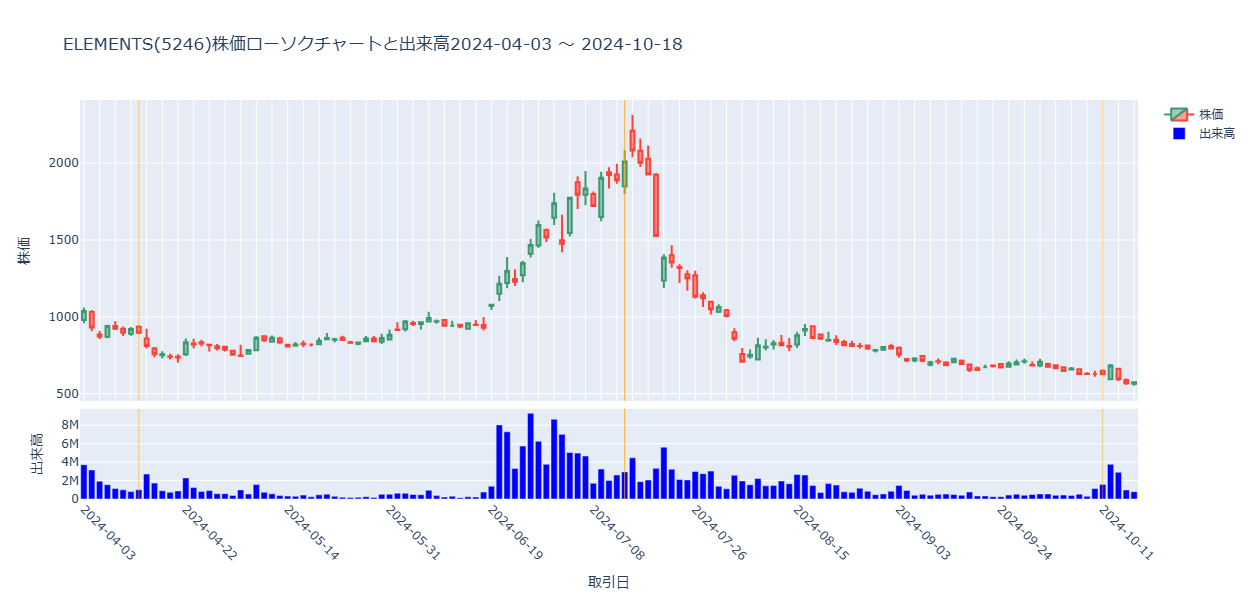

In [54]:
# 日足
KPL = KessanPl()
df = KPL.df.filter(pl.col("announcement_date")<valuation_date).filter(pl.col("code")==code)
ann_date = df["announcement_date"].to_list()[-1]
print(f'決算発表日: {ann_date}')
start_date = ann_date - delta
end_date = ann_date + delta

PFIG = PricelistFig(code, RevPl.df, MPL.df, start_date, end_date)
# 決算発表日にvlineを引く
PFIG.add_vline_announcement_date()
PFIG.fig.show()

In [16]:
updown_rate_df

code,announcement_date,end_date,updown_rate
i64,date,date,f64
1301,2024-08-06,2024-11-06,4.67
1332,2024-08-07,2024-11-06,13.33
1333,2024-08-06,2024-11-11,-3.49
1375,2024-08-09,2024-11-07,6.73
1376,2024-07-11,2024-10-04,-3.01
…,…,…,…
9991,2024-07-26,2024-10-29,-9.93
9993,2024-07-12,2024-10-10,-5.32
9994,2024-08-10,2024-11-14,-5.28


In [9]:
growth_rate_df

code,settlement_date,announcement_date,sales,operating_income,sales_growthrate,diff_operating_income_growthrate
i64,date,date,i64,i64,f64,f64
1301,2018-09-30,2018-11-05,61245,507,null,null
1301,2018-12-31,2019-02-08,78581,2208,null,null
1301,2019-03-31,2019-05-13,58368,551,null,null
1301,2019-06-30,2019-08-02,62644,770,null,null
1301,2019-09-30,2019-11-05,64240,-35,4.9,-18.1
…,…,…,…,…,…,…
9997,2023-09-30,2023-10-31,44263,1939,-2.4,-0.3
9997,2023-12-31,2024-01-31,60173,2630,-2.4,103.5
9997,2024-03-31,2024-05-13,52020,4062,0.2,733.7


In [4]:
#パラメータのセット
# 決算日の指定 -> 指定した日の四半期決算でランキングを作成する
valuation_date = date.today()
valuation_date = date(2024, 9, 26)
settlement_type = "四"
pricelist_df = RevPl.df

In [31]:
# 読み込みと加工
KPL = KessanPl()
df = KPL.get_settlement_performance(settlement_type, pricelist_df)
KPL = KessanPl(df)
df = KPL.get_latest_quater_settlements(valuation_date)
# 売上高25億以上
df = df.filter(pl.col("sales")>=2500)

# sortして出力
df = df.sort(by=["price_change_rate"], descending=[True])
kpl_df = df
kpl_df

code,announcement_date,settlement_date,settlement_type,sales,operating_income,ordinary_profit,final_profit,reviced_eps,dividend,quater,price_change_rate
i64,date,date,str,i64,i64,i64,i64,f64,f64,i64,f64
4935,2024-08-09,2024-06-30,"""四""",2529,144,139,81,13.7,5.7,2,159.1
6557,2024-07-31,2024-06-30,"""四""",3009,116,111,203,65.8,3.9,1,124.7
4348,2024-07-31,2024-06-30,"""四""",20862,1282,1311,831,15.1,6.1,1,124.6
6704,2024-08-09,2024-06-30,"""四""",4572,-822,-800,-815,-54.7,-18.0,1,99.6
6927,2024-08-06,2024-06-30,"""四""",3232,698,721,509,28.1,21.6,1,78.1
…,…,…,…,…,…,…,…,…,…,…,…
4761,2024-07-30,2024-06-30,"""四""",4685,4,49,31,2.9,0.1,1,-48.2
5255,2024-08-14,2024-06-30,"""四""",2542,-6099,-5505,-5554,-161.8,-239.9,2,-51.5
6254,2024-08-09,2024-06-30,"""四""",7629,362,494,411,11.0,4.7,1,-51.9


In [62]:
kpl_df[0:10]

code,announcement_date,settlement_date,settlement_type,sales,operating_income,ordinary_profit,final_profit,reviced_eps,dividend,quater,price_change_rate
i64,date,date,str,i64,i64,i64,i64,f64,f64,i64,f64
4935,2024-08-09,2024-06-30,"""四""",2529,144,139,81,13.7,5.7,2,159.1
6557,2024-07-31,2024-06-30,"""四""",3009,116,111,203,65.8,3.9,1,124.7
4348,2024-07-31,2024-06-30,"""四""",20862,1282,1311,831,15.1,6.1,1,124.6
6704,2024-08-09,2024-06-30,"""四""",4572,-822,-800,-815,-54.7,-18.0,1,99.6
6927,2024-08-06,2024-06-30,"""四""",3232,698,721,509,28.1,21.6,1,78.1
4490,2024-07-12,2024-05-31,"""四""",2520,385,378,60,-0.7,15.3,1,64.8
9067,2024-08-07,2024-06-30,"""四""",11307,243,292,187,6.5,2.1,1,60.6
3738,2024-08-01,2024-06-30,"""四""",104750,3097,4284,2805,50.3,3.0,1,57.4
5010,2024-08-14,2024-06-30,"""四""",5864,799,685,637,32.3,13.6,2,54.6


In [6]:
#####
##### 最新ファンダメンタルズ&業績情報
#####

In [69]:
# parametor
code = 9067

In [70]:
# ファンダメンタルズ
print_finance_quote(PPL.df, FPL.df, code, valuation_date=valuation_date)
print()
SPL.print_stock_df(code, num=4, valuation_date=valuation_date)

丸運(9067)の銘柄情報

終値: 501.0円(2024年09月26日)
予想配当利回り: 2.0%(2024年09月26日)
予想PER: 25.39倍(2024年09月26日)
実績PBR: 0.58倍(2024年09月26日)
自己資本比率: 67.1%(2024年09月26日)
予想ROE: 2.28%(2024年09月26日)
予想ROA: 1.53%(2024年09月26日)
時価総額: 145.1億円(2024年09月26日)

9067(丸運)の四季報データ履歴

発行日: 2024年09月13日
【連続増配】
  貨物輸送は数量横ばいも値上げ浸透。エネルギー輸送も石油の数量減響くが、外注費上昇を受けた運賃改定により伸長。労務費・物流費増こなし営業益続伸。有価証券売却益(約2.5億円)。連続増配。
【提携】
  ベトナム子会社が同国の梱包専門会社の株式約40%を取得。梱包から保管、輸送まで一貫サービス提供へ。需要増にらみ、国内の危険物倉庫の増強を鋭意検討。

発行日: 2024年06月14日
【続伸】
  エネルギー輸送は数量減に加え労務費上昇で軟調。が、貨物輸送は素材物流軸に数量回復、前期価格改定もフル寄与。貨物・海外物流で一貫物流業務の新規業務獲得が上乗せ。営業利益続伸。連続増配。
【営業強化】
  4月貨物輸送事業部に営業開発部を設置、営業情報を全社で共有するシステムも稼働し、新規業務受注強化へ。24年3月川崎市東扇島の毒劇物倉庫が稼働。

発行日: 2024年03月16日
【連続増益】
  貨物は素材物流の数量減響く。エネルギーは暖冬で石油輸送想定以下。ただ基幹システム導入費減で営業増益。25年3月期はエネルギー輸送横ばい。が、貨物輸送は素材物流軸に数量回復。前期価格改定も定着。増益続く。連続増配余地。
【物流問題】
  24年物流問題を受け、鉄道輸送など通運事業への取り組み強化。危険物輸送の需要増にらみ、倉庫増強など検討。

発行日: 2023年12月15日
【増配】
  貨物輸送は素材物流など数量減に加え、航空・海上運賃下落響く。エネルギー輸送も回復緩慢。ただ価格改定が浸透。基幹システム導入費用減や一貫物流での費用抑制効き、営業益は反転増。増配。25年3月期は貨物輸送の取扱数量増える。
【還元】
  24年3月期から連結配当性向50%

In [71]:
# 業績推移
KFIG = KessanFig(code, "四半期", end_settlement_date=valuation_date)
KFIG.add_trace_profits()
KFIG.fig.show()

In [72]:
#####
##### 株価推移
#####

In [73]:
# para
delta = relativedelta(days=100)

In [74]:
# 日足
df = kpl_df.filter(pl.col("code")==code)
ann_date = df["announcement_date"].to_list()[-1]
print(f'決算発表日: {ann_date}')
start_date = ann_date - delta
end_date = ann_date + delta

PFIG = PricelistFig(code, RevPl.df, MPL.df, start_date, end_date)
# 決算発表日にvlineを引く
PFIG.add_vline_announcement_date()
PFIG.fig.show()

決算発表日: 2024-08-07
